# Akantu Tutorial - Loaded elastic plate with a hole

## Problem description

In this tutorial we will describe how to employ **Akantu** to compute the displacement and stress fields within a loaded plate with a hole. 

The hole will play the role of the stress concentrator, as classically described in textbooks.


![](plate-hole.svg)

Because of the symmetries, (and to learn how to use boundary conditions in Akantu), a quarter of the problem will be modeled, this gives the following numerical domain and boundary conditions:

![](plate-hole-2.svg)

## Loading Akantu's module

In [1]:
# loading Akantu
import akantu as aka
#loading numpy (useful for manipulating node/element fields)
import numpy as np

## Ploting modules
For ploting purposes we will use matplotlib

In [2]:
# import the pyplot submodule to draw figures
import matplotlib.pyplot as plt
# import triangluation routine to plot meshes
import matplotlib.tri as tri
# setting a default image size large enough
plt.rcParams['figure.figsize'] = [10, 10]

## Creating a material file for Akantu

In this tutorial we will consider an elastic constitutive law, with a stiffness matching a typical steel. 

The following file *material.dat* descrives such a constitutive law, which we write and then load thanks to *Akantu*'s parsing routines:

In [3]:
material_file = """
material elastic [
    name = steel
    rho = 7800     # density
    E   = 2.1e11   # young's modulus
    nu  = 0.3      # poisson's ratio
]"""
# writing the material file
open('material.dat', 'w').write(material_file)
#reading the material file
material_file = 'material.dat'
aka.parseInput(material_file)

## Creating a discretization mesh

This part of the tutorial provides a geometric description (with Gmsh syntax) of the domain to model.

*Gmsh* mesher will therefore be employed to generate a triangular mesh loadable with Akantu. 

In [4]:
# geometric parameters

w = 10.     # width (x-axis)
l = 5.      # length (y-axis)
h1 = 0.05   # characteristic mesh size at the hole
h2 = 0.3    # characteristic mesh size in corners
R = 2.      # radius of the hole

### Place the points as described on the schematic

The synthax is `Point(id) = {x, y, z, h}`. Z should always be given even for 2D meshes.

In [5]:
mesh_file = f"""
Point(1) = {{0, 0, 0, {h2} }};
Point(2) = {{ {R}, 0, 0, {h1} }};
Point(3) = {{ {w}, 0, 0, {h2} }};
Point(4) = {{ {w}, {l}, 0, {h2} }};
Point(5) = {{ 0,   {l}, 0, {h2} }};
Point(6) = {{0,    {R}, 0, {h1} }};
"""

### Define the lines and the plane surface

In [6]:
mesh_file += """
Circle(1) = {6, 1, 2};
Line(2) = {2, 3};
Line(3) = {3, 4};
Line(4) = {4, 5};
Line(5) = {5, 6};
Line Loop(6) = {1, 2, 3, 4, 5};
Plane Surface(7) = {6};
"""

### Assign names to physical subparts, to simplify the definition of boundary conditions  

In [7]:
mesh_file += """
Physical Surface(8) = {7};
Physical Line("XBlocked") = {5};
Physical Line("YBlocked") = {2};
Physical Line("Traction") = {3};
"""

### Write the file and generate the mesh

In [8]:
open('plate.geo', 'w').write(mesh_file)

import subprocess
ret = subprocess.run("gmsh -2 -order 1 -o plate.msh plate.geo", shell=True)
if ret.returncode:
    print("Beware, gmsh could not run: mesh is not regenerated")
else:
    print("Mesh generated")

Info    : Running 'gmsh -2 -order 1 -o plate.msh plate.geo' [Gmsh 4.8.4, 1 node, max. 1 thread]
Info    : Started on Thu May 18 09:50:39 2023
Info    : Reading 'plate.geo'...
Info    : Done reading 'plate.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.00768018s, CPU 0.003717s)
Info    : Meshing 2D...
Info    : Meshing surface 7 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0657934s, CPU 0.065657s)
Info    : 2058 nodes 4118 elements
Info    : Writing 'plate.msh'...
Info    : Done writing 'plate.msh'
Info    : Stopped on Thu May 18 09:50:39 2023 (From start: Wall 0.0795609s, CPU 0.193663s)
Mesh generated


## Reading the mesh with Akantu

You need to specify the dimension and filename of the mesh to load

In [9]:
# reading the mesh
spatial_dimension = 2    
mesh_file = 'plate.msh'
mesh = aka.Mesh(spatial_dimension)
mesh.read(mesh_file)

### Getting mesh definition to plot it

In [10]:
# extract the mesh
conn = mesh.getConnectivity(aka._triangle_3)
nodes = mesh.getNodes()
triangles = tri.Triangulation(nodes[:, 0], nodes[:, 1], conn)

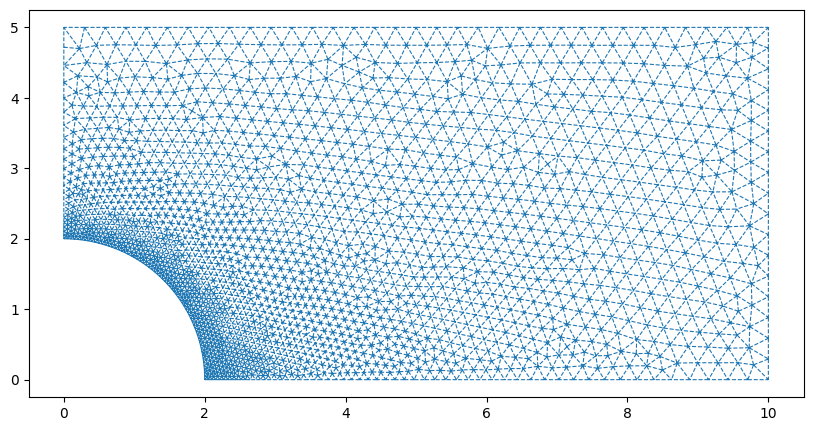

In [11]:
# plot the result
plt.axes().set_aspect('equal')
# plots the pristine state
t = plt.triplot(triangles, '--', lw=.8)

## Configuring the Solver

### Creating a *SolidMechanicsModel* model

In [12]:
# creating the solid mechanics model
model = aka.SolidMechanicsModel(mesh)

### Associating a static solver

In [13]:
# initialize a static solver
model.initFull(_analysis_method=aka._static)

## Declaring boundary conditions

In [14]:
# set the displacement/Dirichlet boundary conditions
model.applyBC(aka.FixedValue(0.0, aka._x), "XBlocked")
model.applyBC(aka.FixedValue(0.0, aka._y), "YBlocked")


# set the force/Neumann boundary conditions
model.getExternalForce()[:] = 0

trac = [10, 0] # Newtons/m^2

model.applyBC(aka.FromTraction(trac), "Traction")

## Solves the problem and save the results

In [15]:
# configure the linear algebra solver
solver = model.getNonLinearSolver()
solver.set("max_iterations", 2)
solver.set("threshold", 1e-10)
solver.set("convergence_type", aka.SolveConvergenceCriteria.residual)

In [16]:
# compute the solution
model.solveStep()

## Ploting the results

### Extracting the displacement field

In [17]:
# extract the displacements
u = model.getDisplacement()

### Plotting the deformed mesh

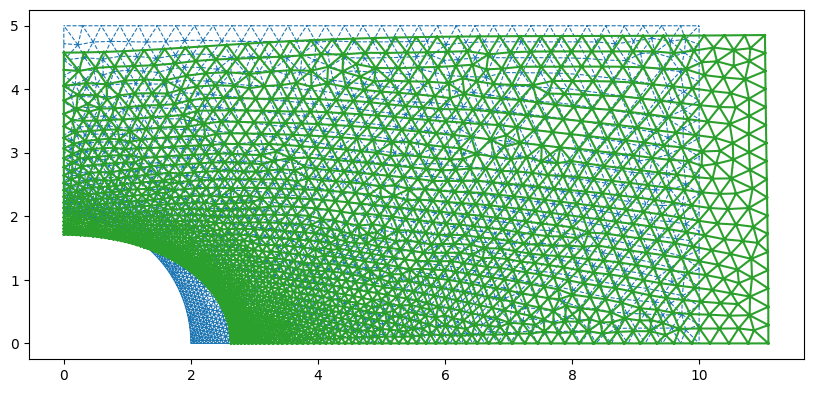

In [18]:
# plot the result
plt.axes().set_aspect('equal')
# plots the pristine state
t = plt.triplot(triangles, '--', lw=.8)
# plots an exagerating view of the strained mesh
t = plt.triplot(nodes[:, 0]+u[:,0]*2e9, nodes[:, 1]+u[:,1]*2e9, triangles=conn)

### Plotting the displacement (nodal field) with colors

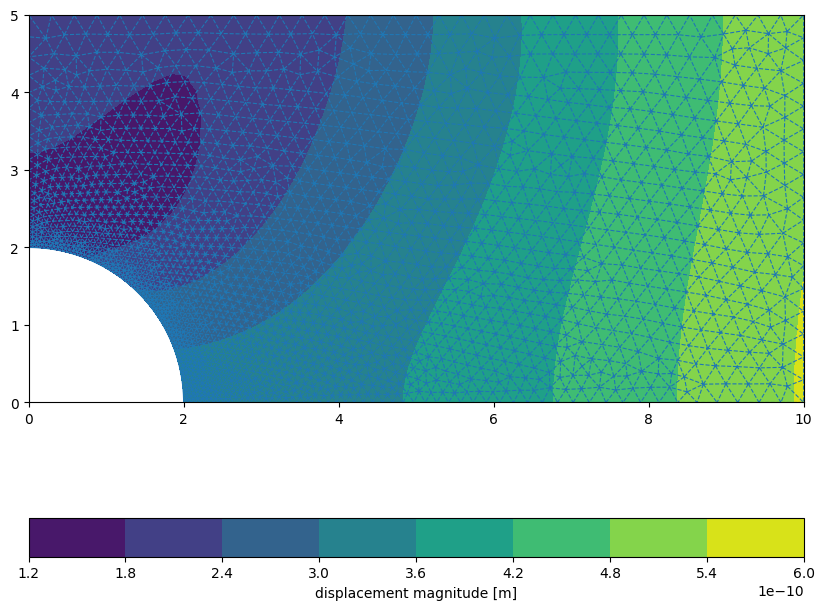

In [19]:
# plot displacement field

plt.axes().set_aspect('equal')

u_disp = plt.tricontourf(triangles, np.linalg.norm(u, axis=1))
t = plt.triplot(triangles, '--', lw=.8)

cbar = plt.colorbar(u_disp, location='bottom')
cbar.set_label('displacement magnitude [m]')

### Extracting and plotting the stress field

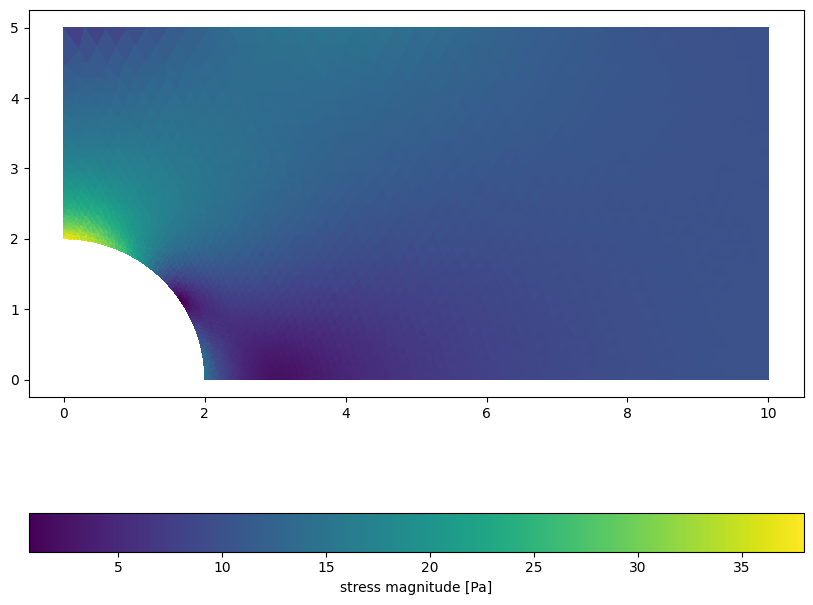

In [20]:
# plot stress field
plt.axes().set_aspect('equal')
stress_field = model.getMaterial(0).getStress(aka._triangle_3)
stress_disp = plt.tripcolor(triangles, np.linalg.norm(stress_field, axis=1))
cbar = plt.colorbar(stress_disp, location='bottom')
cbar.set_label('stress magnitude [Pa]')